# Part 2, XGBoost

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.cross_validation import KFold, train_test_split
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

这部分主要内容就是Xgboost啦

## 数据预处理

In [3]:
train = pd.read_csv('train.csv')

做对数转换

In [4]:
train['log_loss'] = np.log(train['loss'])

数据分成连续和离散特征

In [5]:
features = [x for x in train.columns if x not in ['id','loss', 'log_loss']]

cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['id','loss', 'log_loss']]
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['id','loss', 'log_loss']]

print ("Categorical features:", len(cat_features))
print ("Numerical features:", len(num_features))

Categorical features: 116
Numerical features: 14


And use a label encoder for categorical features:

.astype('category').cat.codes就是对这列进行编码（原本是category类型，现在变为0，1，2...）

In [6]:
ntrain = train.shape[0]

train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
    
print ("Xtrain:", train_x.shape)
print ("ytrain:", train_y.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


## Simple XGBoost Model

首先，训练一个基本的xgboost模型，然后进行参数调节通过交叉验证来观察结果的变换，使用平均绝对误差来衡量

mean_absolute_error(np.exp(y), np.exp(yhat))。


xgboost 自定义了一个数据矩阵类 DMatrix，会在训练开始时进行一遍预处理，从而提高之后每次迭代的效率

In [16]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

### Model

转化成库所支持的底层格式

In [21]:
dtrain = xgb.DMatrix(train_x, train['log_loss']) #用dtrain表示X和y了

## Xgboost参数
- 'booster':'gbtree',
- 'objective': 'multi:softmax', 多分类的问题
- 'num_class':10, 类别数，与 multisoftmax 并用
- 'gamma':损失下降多少才进行分裂
- 'max_depth':12, 构建树的深度，越大越容易过拟合
- 'lambda':2,  控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
- 'subsample':0.7, 随机采样训练样本
- 'colsample_bytree':0.7, 生成树时进行的列采样（对特征进行采样）
- 'min_child_weight':3, 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束
- 'silent':0 ,设置成1则没有运行信息输出，最好是设置为0.
- 'eta': 0.007, 如同学习率
- 'seed':1000,
- 'nthread':7, cpu 线程数

In [26]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

使用交叉验证 `xgb.cv` 

In [24]:
%%time

bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

CV score: 1220.2224526666666
Wall time: 23.1 s


得到了第一个基准结果：MAE＝1220.2224526666666

In [34]:
plt.figure()
bst_cv1[['train-mae-mean','test-mae-mean']].plot()

<Figure size 432x288 with 0 Axes>

### 第一个基础模型：

* 没有发生过拟合
* 只建立了50个树模型


In [35]:
%%time
#建立100个树模型
bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

CV score: 1171.6254069999998
Wall time: 39.1 s


In [39]:
bst_cv2.head()

test-mae-mean  test-mae-std  test-rmse-mean  test-rmse-std  train-mae-mean  \
0    3033.952230     17.058461        6.514562       0.005149     3033.952148   
1    3030.859782     17.058216        5.870088       0.005108     3030.859538   
2    3025.708984     17.064039        5.291149       0.005472     3025.708578   
3    3017.611328     17.071566        4.770140       0.005596     3017.608968   
4    3005.553711     17.082682        4.302140       0.005628     3005.549072   

   train-mae-std  train-rmse-mean  train-rmse-std  
0       8.528313         6.514556        0.002069  
1       8.526956         5.870057        0.001958  
2       8.516089         5.291079        0.001368  
3       8.500935         4.770013        0.001179  
4       8.474960         4.301993        0.001045

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,6)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])

有那么一点过拟合（第一个图中可以看出前60课树在训练集和测试集上的效果差不多说明没有过拟合，第二个图放大了第一个图在40-100区间的图，可以看到在两个集上的效果不相同，说明过拟合了）

得到了新的纪录 **MAE = 1171.625** 比第一次的要好 (1220.2224526666666). 接下来要改变其他参数了。

## XGBoost 参数调节

* Step 1: 选择一组初始参数


* Step 2: 改变 `max_depth` 和 `min_child_weight`.


* Step 3: 调节 `gamma` 降低模型过拟合风险.


* Step 4: 调节 `subsample` 和 `colsample_bytree` 改变数据采样策略.


* Step 5: 调节学习率 `eta`.

In [40]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [41]:
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [42]:
bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50)

In [43]:
bst.kfold(train_x, train_y, nfold=5)

test-mae-mean      1219.292139
test-mae-std          9.577193
test-rmse-mean        0.563140
test-rmse-std         0.002547
train-mae-mean     1210.442505
train-mae-std         1.396269
train-rmse-mean       0.559356
train-rmse-std        0.000600
Name: 49, dtype: float64

### Step 1: 基准模型

### Step 2: 树的深度与节点权重

这些参数对xgboost性能影响最大，因此，他们应该调整第一。简要地概述它们：


* `max_depth`: 树的最大深度。增加这个值会使模型更加复杂，也容易出现过拟合，深度3-10是合理的。

* `min_child_weight`: 正则化参数. 如果树分区中的实例权重小于定义的总和，则停止树构建过程。

In [48]:
xgb_param_grid = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}
xgb_param_grid['max_depth']

[4, 5, 6, 7, 8]

In [49]:
%%time
 
grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 10min 34s


In [50]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1243.19021, std: 6.70267, params: {'min_child_weight': 1, 'max_depth': 4},
  mean: -1243.30650, std: 6.82367, params: {'min_child_weight': 3, 'max_depth': 4},
  mean: -1243.50757, std: 6.60994, params: {'min_child_weight': 6, 'max_depth': 4},
  mean: -1219.60928, std: 7.09978, params: {'min_child_weight': 1, 'max_depth': 5},
  mean: -1218.91318, std: 6.67985, params: {'min_child_weight': 3, 'max_depth': 5},
  mean: -1219.25037, std: 6.89852, params: {'min_child_weight': 6, 'max_depth': 5},
  mean: -1204.68929, std: 6.28732, params: {'min_child_weight': 1, 'max_depth': 6},
  mean: -1203.44652, std: 7.19551, params: {'min_child_weight': 3, 'max_depth': 6},
  mean: -1203.76522, std: 7.13140, params: {'min_child_weight': 6, 'max_depth': 6},
  mean: -1195.35466, std: 6.38662, params: {'min_child_weight': 1, 'max_depth': 7},
  mean: -1194.02731, std: 6.69779, params: {'min_child_weight': 3, 'max_depth': 7},
  mean: -1193.51933, std: 6.73646, params: {'min_child_weight': 6, 'max_dept

网格搜索发现的最佳结果:

`{'max_depth': 8, 'min_child_weight': 6},
 -1187.9597499123447)`
 
设置成负的值是因为要找大的值


In [51]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [57]:
_,scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,3)

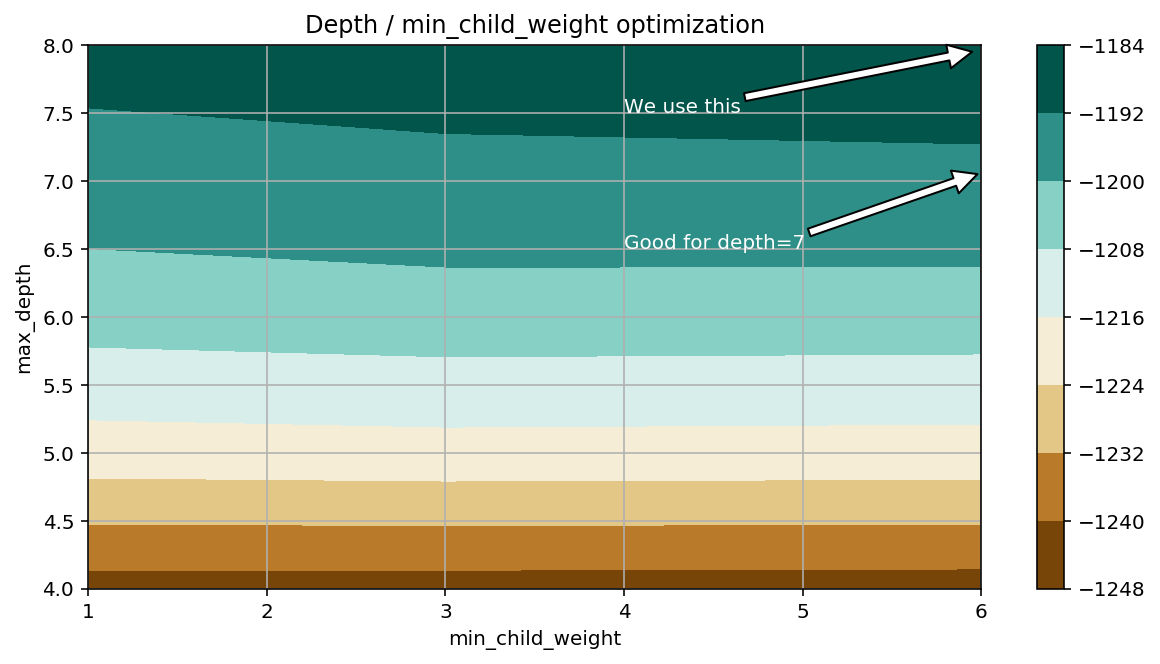

In [58]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this', xy=(5.95, 7.95), xytext=(4, 7.5), arrowprops=dict(facecolor='white'), color='white')
plt.annotate('Good for depth=7', xy=(5.98, 7.05), 
             xytext=(4, 6.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

看到，从网格搜索的结果，分数的提高主要是基于max_depth增加.
min_child_weight稍有影响的成绩，但是，看到，min_child_weight = 6会更好一些。

### Step 3: 调节 gamma去降低过拟合风险

In [62]:
%%time

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 4min 54s


In [63]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1187.93244, std: 6.69469, params: {'gamma': 0.0},
  mean: -1187.67790, std: 6.44330, params: {'gamma': 0.1},
  mean: -1187.66618, std: 6.75004, params: {'gamma': 0.2},
  mean: -1187.21836, std: 7.06771, params: {'gamma': 0.30000000000000004},
  mean: -1188.35006, std: 6.50058, params: {'gamma': 0.4}],
 {'gamma': 0.30000000000000004},
 -1187.218364415095)

我们选择使用偏小一些的 `gamma`.

### Step 4: 调节样本采样方式 subsample 和 colsample_bytree

In [64]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}


grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.2, num_boost_round=50, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
grid.fit(train_x, train_y.values)

Wall time: 9min 46s


In [65]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1185.67109, std: 5.40095, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.6000000000000001},
  mean: -1184.90641, std: 5.61240, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001},
  mean: -1183.73768, std: 6.15639, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.8},
  mean: -1185.09330, std: 7.04214, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.6000000000000001},
  mean: -1184.36147, std: 5.71298, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.7000000000000001},
  mean: -1183.83445, std: 6.24651, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.8},
  mean: -1184.43054, std: 6.68007, params: {'colsample_bytree': 0.8, 'subsample': 0.6000000000000001},
  mean: -1183.33879, std: 5.74985, params: {'colsample_bytree': 0.8, 'subsample': 0.7000000000000001},
  mean: -1182.93099, std: 5.75850, params: {'colsample_bytree': 0.8, 'subsample': 0.8}],
 {'colsample_bytree': 0.8, 

In [66]:
_, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(3,3)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.895, 0.6), xytext=(0.8, 0.695), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show()

在当前的预训练模式的具体案例，得到了下面的结果：

`{'colsample_bytree': 0.8, 'subsample': 0.8},
 -1182.9309918891634)

### Step 5: 减小学习率并增大树个数

学习率也就是每棵树所占的权重

参数优化的最后一步是降低学习速度，同时增加更多的估计量

First, we plot different learning rates for a simpler model (50 trees):

In [67]:
%%time
    
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 7min 56s


下面这里可以看出学习率很小的时候反而效果不好，这是因为树的个数已经确定了（50个），往往减小学习率的时候应该多增加树

In [68]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1203.85842, std: 7.44062, params: {'eta': 0.5},
  mean: -1186.40986, std: 7.73264, params: {'eta': 0.4},
  mean: -1169.84596, std: 7.06513, params: {'eta': 0.3},
  mean: -1160.71337, std: 6.53261, params: {'eta': 0.2},
  mean: -1183.68310, std: 5.94763, params: {'eta': 0.1},
  mean: -1266.36404, std: 7.62575, params: {'eta': 0.075},
  mean: -1711.04360, std: 8.59620, params: {'eta': 0.05},
  mean: -2106.33411, std: 8.55388, params: {'eta': 0.04},
  mean: -2547.20457, std: 8.10850, params: {'eta': 0.03}],
 {'eta': 0.2},
 -1160.7133704502435)

In [85]:
eta, y = convert_grid_scores(grid.grid_scores_)  #这里eta是个dict所以要写成下面列表的形式
eta = [0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

`{'eta': 0.2}, -1160.9736284869114` 是目前最好的结果

现在把树的个数增加到100

In [86]:

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

GridSearchCV(cv=5, error_score='raise',
       estimator=<__main__.XGBoostRegressor object at 0x0000023F8386B160>,
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mae_score, greater_is_better=False), verbose=0)

In [87]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1228.03926, std: 5.85381, params: {'eta': 0.5},
  mean: -1199.57085, std: 7.95164, params: {'eta': 0.4},
  mean: -1177.55751, std: 6.93904, params: {'eta': 0.3},
  mean: -1157.90792, std: 5.63778, params: {'eta': 0.2},
  mean: -1152.33858, std: 6.01793, params: {'eta': 0.1},
  mean: -1156.38090, std: 5.49097, params: {'eta': 0.075},
  mean: -1184.45218, std: 6.53396, params: {'eta': 0.05},
  mean: -1242.77958, std: 7.37036, params: {'eta': 0.04},
  mean: -1467.18453, std: 8.71035, params: {'eta': 0.03}],
 {'eta': 0.1},
 -1152.3385779270316)

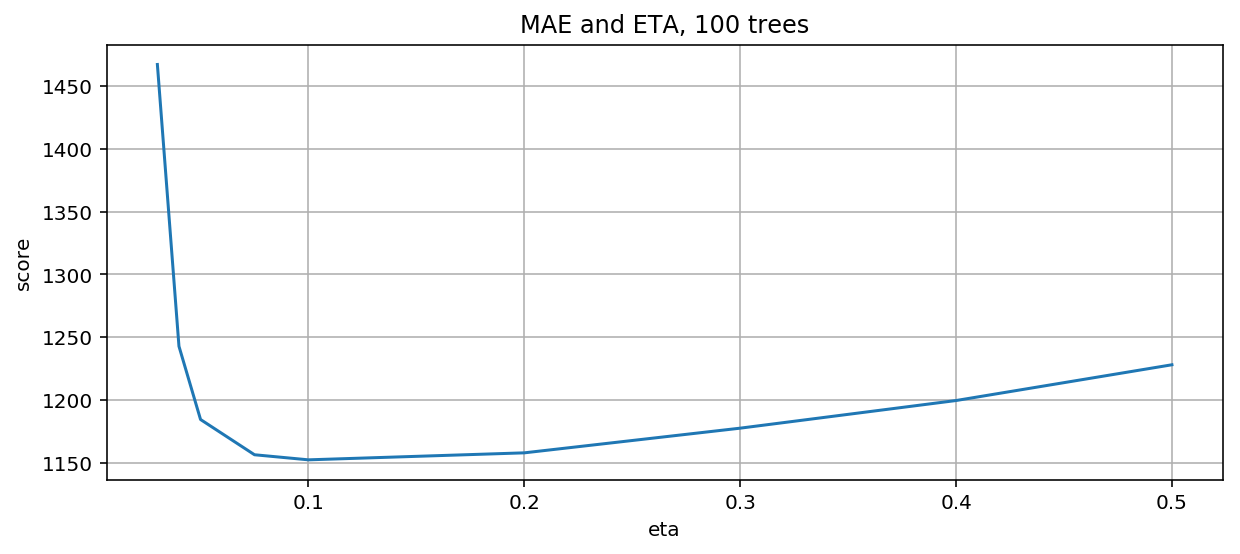

In [89]:
eta, y = convert_grid_scores(grid.grid_scores_)
eta = [0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 100 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

学习率低一些的效果更好

In [90]:
%%time

xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 21min 35s


再增加树的个数

In [91]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1146.52553, std: 5.98131, params: {'eta': 0.09},
  mean: -1145.77895, std: 6.61628, params: {'eta': 0.08},
  mean: -1144.94951, std: 6.35750, params: {'eta': 0.07},
  mean: -1146.62273, std: 6.03952, params: {'eta': 0.06},
  mean: -1148.38192, std: 6.02272, params: {'eta': 0.05},
  mean: -1152.19322, std: 5.95718, params: {'eta': 0.04}],
 {'eta': 0.07},
 -1144.9495115281882)

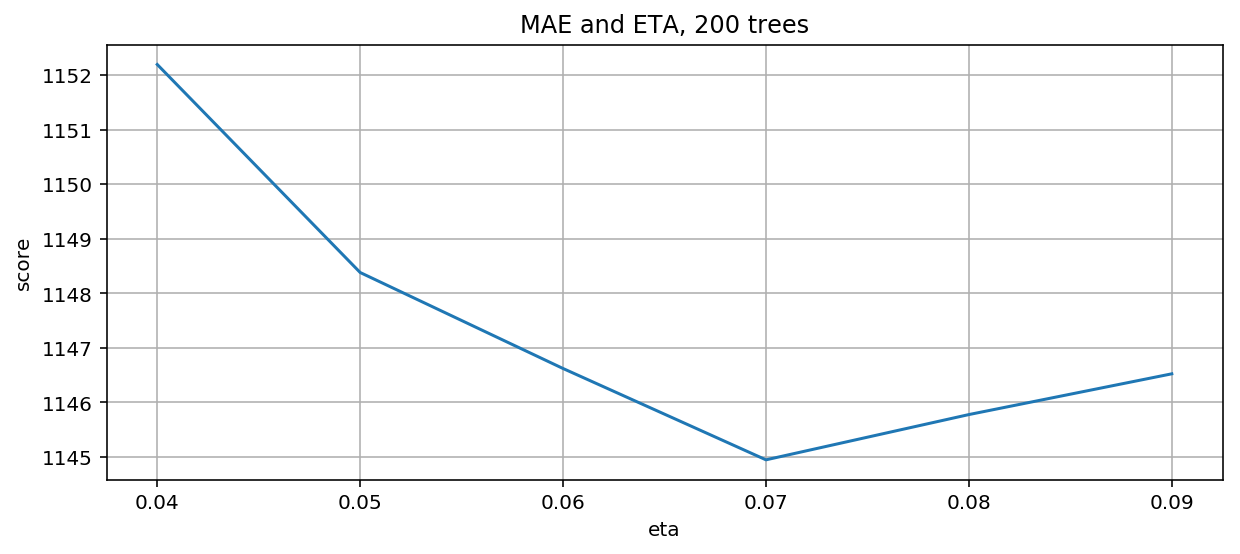

In [93]:
eta, y = convert_grid_scores(grid.grid_scores_)
eta = [0.09,0.08,0.07,0.06,0.05,0.04]
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 200 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [94]:
%%time

# Final XGBoost model


bst = XGBoostRegressor(num_boost_round=200, eta=0.07, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9)
cv = bst.kfold(train_x, train_y, nfold=5)

Wall time: 3min 41s


In [95]:
cv

test-mae-mean      1145.066065
test-mae-std          7.996415
test-rmse-mean        0.537405
test-rmse-std         0.002105
train-mae-mean     1040.134668
train-mae-std         2.292600
train-rmse-mean       0.495751
train-rmse-std        0.000926
Name: 199, dtype: float64

看到200棵树最好的ETA是0.07。正如所预料的那样，ETA和num_boost_round依赖关系不是线性的，但是有些关联。

花了相当长的一段时间优化xgboost. 从初始值: **1219.57**. 经过调参之后达到 **MAE=1171.77**.

还发现参数之间的关系` ETA `和` num_boost_round `：

* 100 trees, `eta=0.1`: **MAE=1152.247**
* 200 trees, `eta=0.07`: **MAE=1145.92**


`XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6, colsample_bytree=0.6, subsample=0.9, eta=0.07).`

